# 1. Classifier-free guidance в ограниченном промежутке

На лекции с ноутбуком мы познакомились с Classifier-free Guidance (CFG): техникой для балансирования между качеством и разнообразием генерации из условных диффузионных моделей. Минусом этой схемы является увеличение числа вызовов нейросети в 2 раза по сравнению с обычной условной генерацией. В этой части домашки мы попробуем уменьшить количество применений CFG с сохранением (или даже улучшением) качества генерации.

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [2]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, ToTensor

In [3]:
%cd /kaggle/input/diffusion

%cp cmnist_train.npz ../../working
%cp cond_cunet.pkl ../../working
%cp cunet.pkl ../../working
%cp fid.py ../../working
%cp cunet.py ../../working

%cd ../../working

/kaggle/input/diffusion
/kaggle/working


## Цветной MNIST

В домашке предлагается поработать с цветной модификацией датасета MNIST (код для покраски взят [у коллег](https://github.com/ngushchin/EntropicNeuralOptimalTransport/blob/main/src/tools.py) из Сколтеха). С одной стороны, такой датасет все еще оставляет возможность обучать диффузионные модели, но делает свойства модели более интерпретируемыми (например, в задачах условной генерации, таких, как дорисовывание, повышение разрешения и деблюринг, можно отследить корректное сохранение цвета изображения).

In [4]:
class ColoredMNIST(MNIST):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hues = 360 * torch.rand(super().__len__())

    def __len__(self):
        return super().__len__()

    def color_image(self, img, idx):
        img_min = 0
        a = (img - img_min) * (self.hues[idx] % 60) / 60
        img_inc = a
        img_dec = img - a

        colored_image = torch.zeros((3, img.shape[1], img.shape[2]))
        H_i = round(self.hues[idx].item() / 60) % 6

        if H_i == 0:
            colored_image[0] = img
            colored_image[1] = img_inc
            colored_image[2] = img_min
        elif H_i == 1:
            colored_image[0] = img_dec
            colored_image[1] = img
            colored_image[2] = img_min
        elif H_i == 2:
            colored_image[0] = img_min
            colored_image[1] = img
            colored_image[2] = img_inc
        elif H_i == 3:
            colored_image[0] = img_min
            colored_image[1] = img_dec
            colored_image[2] = img
        elif H_i == 4:
            colored_image[0] = img_inc
            colored_image[1] = img_min
            colored_image[2] = img
        elif H_i == 5:
            colored_image[0] = img
            colored_image[1] = img_min
            colored_image[2] = img_dec

        return colored_image

    def __getitem__(self, idx):
        img, label = super().__getitem__(idx)
        return self.color_image(img, idx), label

In [5]:
transform = Compose([Resize((32, 32)), ToTensor()])
# data_train = ColoredMNIST(root='', train=True, download=False, transform=transform)
# раскомментируйте, чтобы скачать
data_train = ColoredMNIST(root='', train=True, download=True, transform=transform)

data_test = ColoredMNIST(root='', train=False, download=False, transform=transform)
train_dataloader = DataLoader(data_train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(data_test, batch_size=64, shuffle=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 12742060.14it/s]


Extracting ColoredMNIST/raw/train-images-idx3-ubyte.gz to ColoredMNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 335620.09it/s]


Extracting ColoredMNIST/raw/train-labels-idx1-ubyte.gz to ColoredMNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 3178591.96it/s]


Extracting ColoredMNIST/raw/t10k-images-idx3-ubyte.gz to ColoredMNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 1949501.51it/s]

Extracting ColoredMNIST/raw/t10k-labels-idx1-ubyte.gz to ColoredMNIST/raw



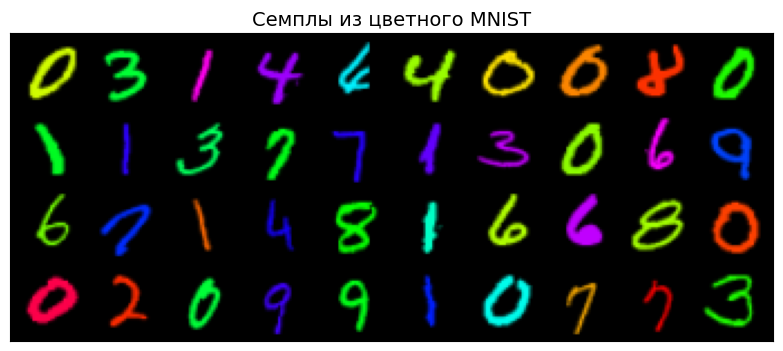

In [6]:
from torchvision.utils import make_grid

def remove_ticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=False,
        labelleft=False
    )

def remove_xticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=True,
        labelleft=True
    )

def visualize_batch(img_vis, title='Семплы из цветного MNIST', nrow=10, ncol=4):
    img_grid = make_grid(img_vis, nrow=nrow)
    fig, ax = plt.subplots(1, figsize=(nrow, ncol))
    remove_ticks(ax)
    ax.set_title(title, fontsize=14)
    ax.imshow(img_grid.permute(1, 2, 0))
    plt.show()


visualize_batch(next(iter(train_dataloader))[0][:40])

## Предобученная диффузионная модель

Для дальнейшей работы с разного вида условной генерации нам понадобится предобученная **условная** диффузионная модель. Мы будем использовать простенькую архитектуру, которая была получена скрещиванием CUNet из того же [репозитория](https://github.com/ngushchin/EntropicNeuralOptimalTransport/blob/main/src/cunet.py) и части, кодирующей момент времени и метку класса, из SongUNet в [EDM](https://github.com/NVlabs/edm/blob/main/training/networks.py).

Такой выбор был мотивирован следующими наблюдениями:
* Готовые качественные архитектуры (те же SongUNet или DhariwalUNet) достаточно долго работают из-за своей глубины, что усложнит решение домашки, в которой, в основном, важны качественные результаты;
* Существующие имплементации этих архитектур достаточно абстрактно написаны, чтобы при первом знакомстве было удобно писать для них разного рода надстройки.

Архитектура CUNet представляет собой гораздо более легкую и неглубокую модель, за счет чего существенно ускоряет работу с ней и упрощает ее модификацию. Кодирование метки класса и момента времени везде более-менее одинаково (и включает в себя позиционное кодирование/positional encoding), поэтому выбор именно варианта из EDM не существенен.

Как и в семинаре, мы используем надстройку над архитектурой, которая делает все необходимые преобразования над входами: нормирование, взятие логарифма от уровня шума и т.д. Ее имплементация на этот раз взята из репозитория EDM, поэтому загрузка модели выглядит немного необычным образом. Можно не обращать внимания на устройство кода в следующих двух ячейках (небольшая часть кода из гитхаба EDM была изменена для удобства использования в ноутбуке).

In [7]:
!git clone https://github.com/NVlabs/edm
!cp edm/training/networks.py edm/training/networks_copy.py
!cp fid.py edm/fid.py

Cloning into 'edm'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 54 (delta 13), reused 13 (delta 13), pack-reused 20 (from 1)
Receiving objects: 100% (54/54), 2.13 MiB | 30.23 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [8]:
def append_code(in_files, out_file):
    lines = ['\n']
    for in_file in in_files:
        with open(in_file, 'r') as f:
            for line in f:
                lines.append(line)

    with open(out_file, 'w') as f:
        for line in lines:
            f.write(line)

append_code(['edm/training/networks_copy.py', 'cunet.py'], 'edm/training/networks.py')

In [9]:
import pickle
%cd edm
from training.networks import EDMPrecond
from torch_utils import misc
from dnnlib import util
%cd ..

cond_model = EDMPrecond(img_resolution=32, img_channels=3, model_type='CUNet', noise_channels=128, base_factor=64, emb_channels=128, label_dim=11)
cond_model.eval().to("cuda")

with util.open_url('cond_cunet.pkl') as f:
    data = pickle.load(f)

misc.copy_params_and_buffers(src_module=data['ema'], dst_module=cond_model, require_all=True)
print(f"Модель имеет {sum(p.numel() for p in cond_model.parameters())} параметров")

/kaggle/working/edm
/kaggle/working
Модель имеет 17549763 параметров


Возьмем слегка модифицированный код для генерации и визуализации из семинара и посмотрим, как работает модель. Здесь в схеме Эйлера появились два новых гиперпараметра: **iter_start** и **iter_end**, соответствующие началу и концу отрезка, на котором используется CFG.

In [10]:
def normalize(x):
    return x / x.abs().max(dim=0)[0][None, ...]

def velocity_from_denoiser(x, model, sigma, class_labels=None, error_eps=1e-4, stochastic=False, cfg=0.0, **model_kwargs):
    sigma = sigma[:, None, None, None]
    cond_v = (-model(x, sigma, class_labels, **model_kwargs) + x) / (sigma + error_eps)

    if cfg > 0.0:
        dummy_labels = torch.zeros_like(class_labels)
        dummy_labels[:, -1] = 1
        uncond_v = (-model(x, sigma, dummy_labels, **model_kwargs) + x) / (sigma + error_eps)
        v = cond_v + cfg * (cond_v - uncond_v)
    else:
        v = cond_v

    if stochastic:
        v = v * 2

    return v

def get_timesteps(params):
    num_steps = params['num_steps']
    sigma_min, sigma_max = params['sigma_min'], params['sigma_max']
    rho = params['rho']

    step_indices = torch.arange(num_steps, device=params['device'])
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])]) # t_N = 0
    return t_steps

def sample_euler(model, noise, params, class_labels=None, **model_kwargs):
    num_steps = params['num_steps']
    vis_steps = params['vis_steps']
    t_steps = get_timesteps(params)
    x = noise * params['sigma_max']
    x_history = [normalize(noise)]
    with torch.no_grad():
        for i in range(len(t_steps) - 1):
            t_cur = t_steps[i]
            t_next = t_steps[i + 1]
            t_net = t_steps[i] * torch.ones(x.shape[0], device=params['device'])
            if (i >= params['iter_start'] and i <= params['iter_end']):
                x = x + velocity_from_denoiser(x, model, t_net, class_labels=class_labels, stochastic=params['stochastic'], cfg=params['cfg'], **model_kwargs) * (t_next - t_cur)
            else:
                x = x + velocity_from_denoiser(x, model, t_net, class_labels=class_labels, stochastic=params['stochastic'], cfg=0.0, **model_kwargs) * (t_next - t_cur)

            if params['stochastic']:
                x = x + torch.randn_like(x) * torch.sqrt(torch.abs(t_next - t_cur) * 2 * t_cur)
            x_history.append(normalize(x).view(-1, 3, *x.shape[2:]))

    x_history = [x_history[0]] + x_history[::-(num_steps // (vis_steps - 2))][::-1] + [x_history[-1]]

    return x, x_history

def visualize_model_samples(model, params, labels_usage='dummy', class_labels=None, title='Семплы из модели', **model_kwargs):
    noise = torch.randn(40, 3, 32, 32, device=params['device'])
    if class_labels is None and labels_usage == 'dummy':
        class_labels = torch.zeros(40, 11, device=params['device'])
        class_labels[:, -1] = 1
    elif labels_usage == 'random':
        class_labels = torch.randint(low=0, high=10, size=(40,), device=params['device'])
        class_labels = (class_labels[:, None] == torch.arange(11, device=params['device'])[None, :]).float()

    out, trajectory = sample_euler(model, noise, params, class_labels=class_labels, **model_kwargs)
    out = out * 0.5 + 0.5
    visualize_batch(out.detach().cpu(), title=title)

Безусловную генерацию из условной модели можно реализовать двумя способами: подав метку фиктивного класса (как в classifier-free guidance) или сгенерировав случайную метку класса и подав ее на вход. Сгенерируем обоими способами.

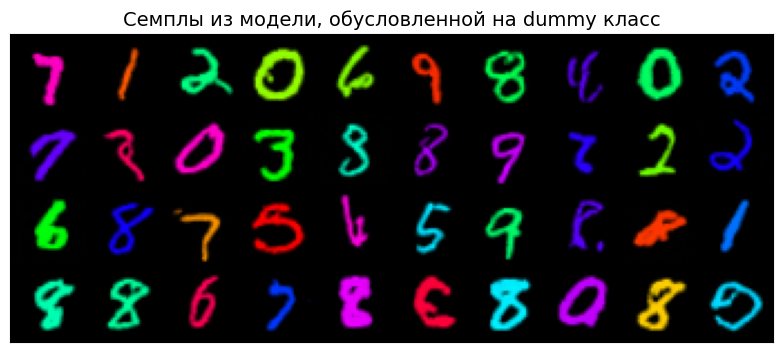

In [11]:
sampling_params = {
    'device': 'cuda',
    'sigma_min': 0.02,
    'sigma_max': 80.0,
    'num_steps': 50,
    'rho': 7.0,
    'vis_steps': 1,
    'stochastic': False,
    'cfg': 0.0,
    'iter_start': 0,
    'iter_end': 50
}

visualize_model_samples(cond_model, params=sampling_params, labels_usage='dummy', title='Семплы из модели, обусловленной на dummy класс')

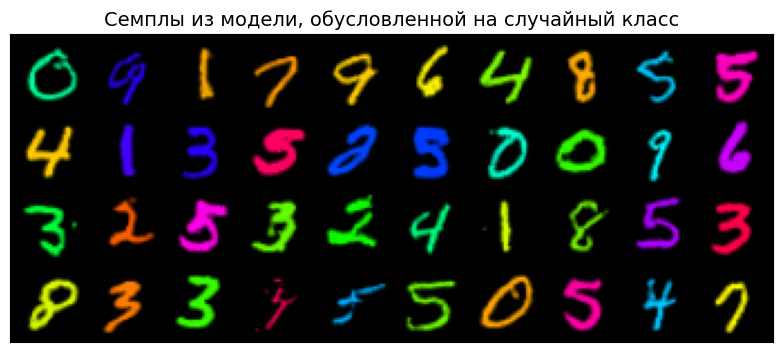

In [12]:
visualize_model_samples(cond_model, params=sampling_params, labels_usage='random', title='Семплы из модели, обусловленной на случайный класс')

Также визуализируем условные семплы из модели с разными коэффициентами classifier-free guidance.

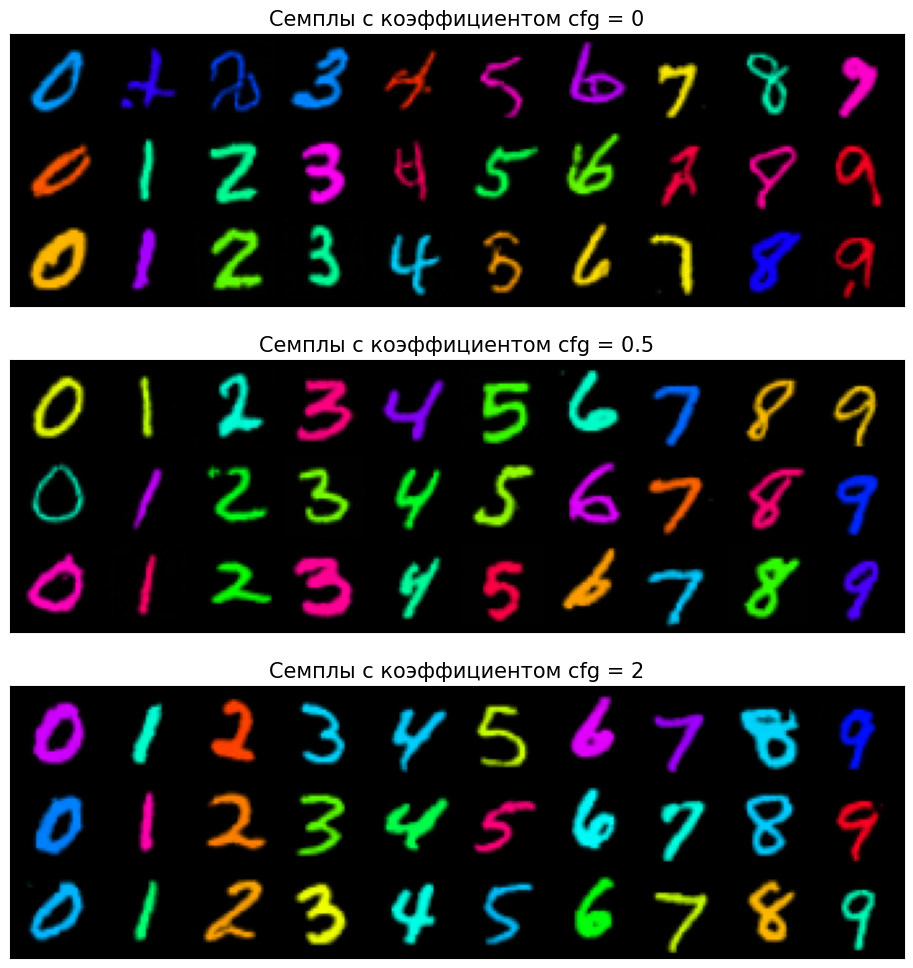

In [13]:
def visualize_cond_samples(model, params, n_samples=3, cfgs=[0.0, 0.5, 2.0], **model_kwargs):
    fig, ax = plt.subplots(len(cfgs), figsize=(12, 12))
    for i in range(len(cfgs)):
        remove_ticks(ax[i])
        ax[i].set_title('Семплы с коэффициентом cfg = %.4g' % cfgs[i], fontsize=15)

    for i in range(len(cfgs)):
        cfg = cfgs[i]
        noise = torch.randn(n_samples * 10, 3, 32, 32, device=params['device'])
        class_labels = torch.eye(n=10, m=11).unsqueeze(0).repeat(n_samples, 1, 1).reshape(-1, 11).float().to(params['device'])
        params['cfg'] = cfgs[i]
        img, _ = sample_euler(model, noise, params, class_labels=class_labels, **model_kwargs)
        img = img * 0.5 + 0.5
        img_grid = make_grid(img, nrow=10)
        ax[i].imshow(img_grid.permute(1, 2, 0).detach().cpu())

sampling_params = {
    'device': 'cuda',
    'sigma_min': 0.02,
    'sigma_max': 80.0,
    'num_steps': 50,
    'rho': 7.0,
    'vis_steps': 1,
    'stochastic': False,
    'iter_start': 0,
    'iter_end': 50
}

visualize_cond_samples(cond_model, sampling_params)

## Метрики качества генерации

Для домашки пригодится мерить качество моделей генерации. Как это сделать? Сходу не очень очевидно, если поставлена задача безусловной генерации, в которой нет ground truth сопоставления входа выходу. В такой ситуации стоит вспомнить, что задача генеративного моделирования, в первую очередь, состоит в приближении моделью распределения датасета. Разумной метрикой качества послужит какое-нибудь расстояние между распределением данных и распределением, порожденным генеративной моделью.


Распределениями мы, к сожалению, не располагаем, зато располагаем обучающим датасетом $\boldsymbol{X}_1, \ldots, \boldsymbol{X}_N$ и сгенерированной выборкой $\boldsymbol{Y}_1, \ldots, \boldsymbol{Y}_M$, поэтому нужно прибегать к оценке расстояния между распределениями по семплам. Беда состоит в том, что в высокой размерности классические методы восстановления плотности (метод гистограмм, ядерная оценка плотности (KDE) и т.д.), которые можно было бы применить к данным, чтобы потом получить две плотности $\hat{p}_{\boldsymbol{X}}$ и $\hat{p}_{\boldsymbol{Y}}$, работают очень плохо. Помимо этого, приблизить два набора данных некоторым простым распределением типа гауссовского тоже не самая корректная процедура: картиночные данные принципиально многомодальные, и такое приближение будет плохим.

На основе этих наблюдений была предложена следующая идея. Во-первых, данные можно "упростить", если перевести их в некоторое семантическое пространство с более осмысленным расстоянием, чем попиксельное $L_2$ между картинками. Есть шанс, что такое преобразование позволит сгруппировать данные и сделать распределение ближе к унимодальному (особенно, если при этом размерность снижается). В качестве такого пространства предлагается взять нейросеть, "видевшую все", обученную на классификацию какого-нибудь большого датасета, и взять ее признаковое пространство. Таким образом, наши новые данные — $f(\boldsymbol{X}_1), \ldots, f(\boldsymbol{X}_N)$ и $f(\boldsymbol{Y}_1), \ldots, f(\boldsymbol{Y}_M)$, где $f$ — функция, соответсвующая выходу нейросети перед классификационным слоем (который как раз отвечает за выделенные в объекте признаки). Исторически в качестве такой нейросети используется [InceptionV3](https://arxiv.org/abs/1512.00567), обученная на классификацию [ImageNet](https://www.image-net.org/).

Метрика [Fréchet Inception Distance (FID)](https://arxiv.org/abs/1706.08500), построенная на данной идее, заканчивает ее максимально просто. Оба набора данных приближаются гауссовскими распределениями с параметрами, равными соответствующим выборочным среднему и дисперсии:
$$
    \hat{p}_{f(\boldsymbol{X})}(\boldsymbol{z}) = \mathcal{N}(\boldsymbol{z} \mid \mu_{\boldsymbol{X}}, \Sigma_{\boldsymbol{X}}); \:\:\:\:\: \hat{p}_{f(\boldsymbol{Y})}(\boldsymbol{z}) = \mathcal{N}(\boldsymbol{z} \mid \mu_{\boldsymbol{Y}}, \Sigma_{\boldsymbol{Y}}),
$$
$$
    \mu_{\boldsymbol{X}} = \frac{1}{N} \sum\limits_{i = 1}^{N} f(\boldsymbol{X}_i), \:\:\:\: \Sigma_{\boldsymbol{X}} = \frac{1}{N} \sum\limits_{i = 1}^{N} \left(f(\boldsymbol{X}_i) - \mu_{\boldsymbol{X}} \right)\left(f(\boldsymbol{X}_i) - \mu_{\boldsymbol{X}} \right)^{\top}
$$
$$
    \mu_{\boldsymbol{Y}} = \frac{1}{M} \sum\limits_{j = 1}^{M} f(\boldsymbol{Y}_j), \:\:\:\: \Sigma_{\boldsymbol{Y}} = \frac{1}{M} \sum\limits_{j = 1}^{M} \left(f(\boldsymbol{Y}_j) - \mu_{\boldsymbol{Y}} \right)\left(f(\boldsymbol{Y}_j) - \mu_{\boldsymbol{Y}} \right)^{\top}.
$$

После таких манипуляций получились два распределения с явно заданной плотностью, между которыми уже можно вычислить некоторое расстояние. Одним из известных расстояний между распределениями является расстояние Вассерштейна, которое тесно связано с задачей оптимального транспорта и еще будет упомянуто в курсе. Сейчас же для нас важно то, что у такого расстояния есть явно заданная формула:

$$
    \mathcal{W}_2 (\mathcal{N}(\mu_{\boldsymbol{X}}, \Sigma_{\boldsymbol{X}}), \mathcal{N}(\mu_{\boldsymbol{Y}}, \Sigma_{\boldsymbol{Y}})) = \|\mu_{\boldsymbol{X}} - \mu_{\boldsymbol{Y}}\|^2 + \text{Tr}\left(\Sigma_{\boldsymbol{X}} + \Sigma_{\boldsymbol{Y}} - 2 \left(\Sigma_{\boldsymbol{X}} \Sigma_{\boldsymbol{Y}} \right)^{\frac{1}{2}} \right) = \|\mu_{\boldsymbol{X}} - \mu_{\boldsymbol{Y}}\|^2 + \|\sqrt{\Sigma_{\boldsymbol{X}}} - \sqrt{\Sigma_{\boldsymbol{Y}}} \|_{\text{F}}^2.
$$

Ее смысл очень простой: расстояние между двумя нормальными распределениями считается как квадрат расстояния между их средними плюс квадрат расстояния между корнями из матриц ковариации (в одномерном случае это квадрат расстояния между стандартными отклонениями).

Есть разные подходы к подсчету FID'a для разных задач, но в задаче безусловной генерации обычно считают то, насколько близки статистики сгенерированных изображений (часто берут 50000) к статистикам трейн датасета. Таким образом, мы измеряем то, насколько хорошо модель выучила распределение обучающих данных. Метрика достаточно чувствительна к количеству семплов и имеет тенденцию к недооценке реального расстояния, если взято небольшое количество семплов (проблемы во многом лезут из матрицы ковариаций, которая вырождена всегда, когда семплов меньше, чем их размерность). Тем не менее, на MNIST'е даже такое небольшое количество семплов, как **3000**, дает адекватное приближение. Здесь мы посчитаем FID на **3000** семплах, чтобы экономить время (такое количество семплов дает переоценку примерно на один-два пункта по сравнению с полноценным количеством семплов).

In [14]:
import os, shutil
from tqdm import tqdm

# сохраним семплы из модели для дальнейшего подсчета FID
# labels_usage: если dummy, то мы передаем в модель класс 10, который соответствует безусловной генерации
# если uniform, то мы генерируем по num_samples / 10 изображений каждого класса


def save_model_samples(name, model, params, batch_size, num_samples, labels_usage='dummy', **model_kwargs):
    os.makedirs(name, exist_ok=True) # и пересоздается
    shutil.rmtree(name) # перед сохранением изображений в папку папка очищается
    os.makedirs(name, exist_ok=True) # и пересоздается
    count = 0

    assert num_samples % 10 == 0

    with tqdm(total= num_samples) as pbar:
        while count < num_samples:
            cur_batch_size = min(num_samples - count, batch_size)
            noise = torch.randn(cur_batch_size, 3, 32, 32, device=params['device'])
            if labels_usage == 'dummy':
                labels = torch.zeros(cur_batch_size, 11, device=params['device'])
                labels[:, -1] = 1
            elif labels_usage == 'uniform':
                idxs = torch.arange(count, count + cur_batch_size, device=params['device'])
                labels = idxs // (num_samples / 10)
                labels = (labels[:, None] == torch.arange(11, device=labels.device)[None, :]).float()
            else:
                raise NotImplementedError

            out, trajectory = sample_euler(model, noise, params, class_labels=labels, **model_kwargs)
            out = (out * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
            for i in range(out.shape[0]):
                img = Image.fromarray(out[i])
                n_digits = len(str(count))
                img_name = (6 - n_digits) * '0' + str(count) + '.png'
                img.save(os.path.join(name, img_name))
                count += 1
                pbar.update(1)
                pbar.set_description('%d images saved' % (count,))

# возьмем реализацию подсчета FID из EDM
%cd edm
from fid import calculate_inception_stats, calculate_fid_from_inception_stats
from dnnlib.util import open_url
%cd ..

def calc_fid(image_path, ref_path, num_expected, batch):
    with open_url(ref_path) as f:
        ref = dict(np.load(f))

    mu, sigma = calculate_inception_stats(image_path=image_path, num_expected=num_expected, max_batch_size=batch)
    fid = calculate_fid_from_inception_stats(mu, sigma, ref['mu'], ref['sigma'])
    return fid

/kaggle/working/edm
/kaggle/working


In [15]:
for cfg in [0.0, 0.5, 2.0]:
    sampling_params = {
        'device': 'cuda',
        'sigma_min': 0.02,
        'sigma_max': 80.0,
        'num_steps': 50,
        'rho': 7.0,
        'vis_steps': 1,
        'stochastic': False,
        'cfg': cfg,
        'iter_start': 0,
        'iter_end': 50,
    }
    save_model_samples('cunet_cond_samples', cond_model, sampling_params, batch_size=128, num_samples=3000, labels_usage='uniform')
    fid = calc_fid('cunet_cond_samples', 'cmnist_train.npz', num_expected=3000, batch=128)
    print('Модель с cfg = %.2g имеет FID = %.4g' % (sampling_params['cfg'], fid,))

3000 images saved: 100%|██████████| 3000/3000 [01:13<00:00, 41.06it/s]

Loading Inception-v3 model...

 done
Loading images from "cunet_cond_samples"...
Calculating statistics for 3000 images...


100%|██████████| 24/24 [00:06<00:00,  3.98batch/s]


Модель с cfg = 0 имеет FID = 3.177


3000 images saved: 100%|██████████| 3000/3000 [02:21<00:00, 21.24it/s]


Loading Inception-v3 model...
Loading images from "cunet_cond_samples"...
Calculating statistics for 3000 images...


100%|██████████| 24/24 [00:05<00:00,  4.07batch/s]


Модель с cfg = 0.5 имеет FID = 3.335


3000 images saved: 100%|██████████| 3000/3000 [02:21<00:00, 21.22it/s]


Loading Inception-v3 model...
Loading images from "cunet_cond_samples"...
Calculating statistics for 3000 images...


100%|██████████| 24/24 [00:05<00:00,  4.06batch/s]


Модель с cfg = 2 имеет FID = 5.64


Как видим, эффект от CFG примерно следующий: при его добавлении с небольшим коэффициентом FID улучшается (за счет того, что разнообразие не сильно портится, а качество семплов становится лучше). Добавление же CFG с коэффициентом 2.0 качество ухудшает, поскольку слишком сильно портит разнообразие. На самом же деле, оба варианта использования CFG (с маленьким и большим коэффициентом) неоптимальны. Оптимальным будет использование CFG не на всем временном промежутке, а только на некотором его подотрезке. Таким образом, мы не только сможем ускорить генерацию из модели по сравнению с использованием CFG на всем промежутке, но и сможем добиться улучшением качества

## Задача 1 (0.5 баллов)

Исследуйте влияние ширины и середины "окна" использования CFG на качество генерации. Зафиксируйте набор гиперпараметров в следующей ячейке, стартовый шум размерности $(10, 3, 32, 32)$, из которого будут сгенерированы 10 изображений, соответствующих 10 цифрам. Визуализируйте, как меняются картинки, сгенерированные из одного и того же шума, при сдвиге окна слева направо и при расширении ширины окна. 

Эксперимент со сдвигом окна слева направо лучше проводить со средней шириной окна (10-20 на 50 шагов генерации). После визуализации изменения качества при сдвиге слева направо, зафиксируйте позицию середины окна, которая, как вам кажется, порождает наиболее качественные семплы. После этого из полученной середины окна визуализируйте результаты генерации с различной шириной окна. Для обоих экспериментов лучше делать небольшой шаг по позиции или ширине (например, 5), чтобы не упустить резких качественных изменений.

Опишите ваши наблюдения и выводы. В каком участке семплирования стоит использовать CFG, а где это не оправдано? Всегда ли увеличение ширины окна приводит к улучшению качества? Каким (приблизительно) значениям в терминах уровня шума $\sigma$ соответствуют итерации, в которых, как вам кажется, имеет смысл использовать CFG? 

Сначала поэкспериментируем с широной окна: возьмём ширину с шагом 5 от нуля и до 50 и будем работать с центральным окном.

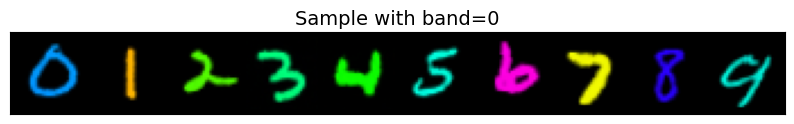

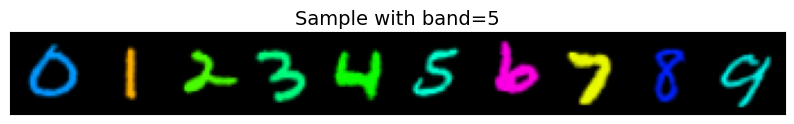

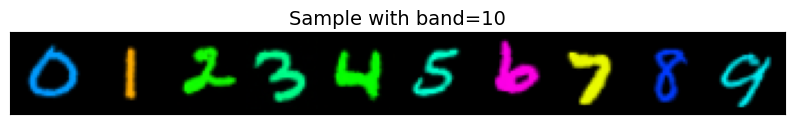

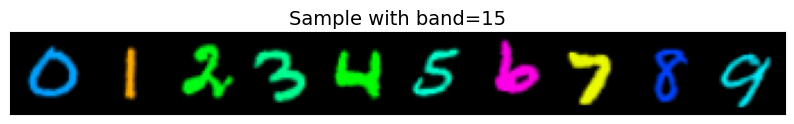

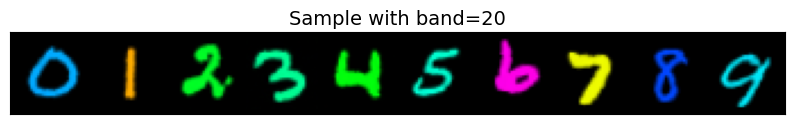

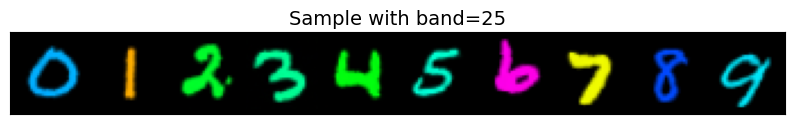

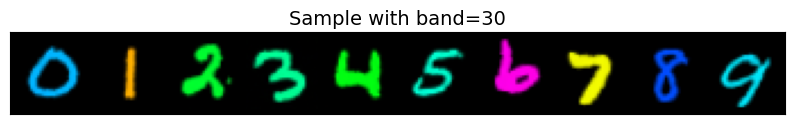

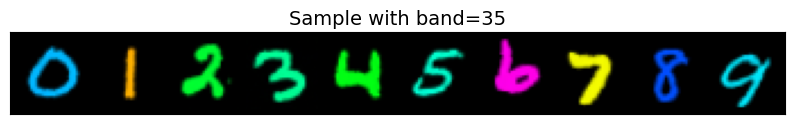

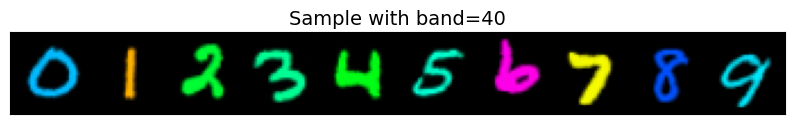

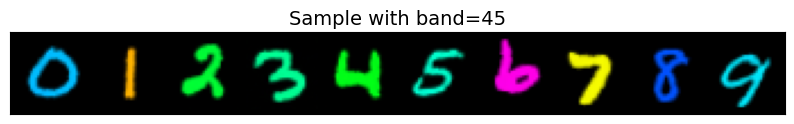

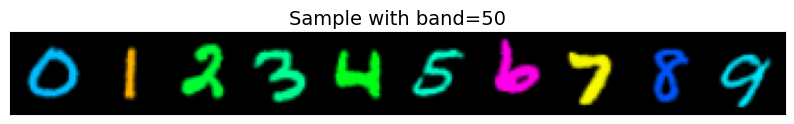

In [16]:
noise = torch.randn(10, 3, 32, 32, device="cuda")
bandwidth = np.arange(0, 55, 5)
for band in bandwidth:
    sampling_params = {
        'device': 'cuda',
        'sigma_min': 0.02,
        'sigma_max': 80.0,
        'num_steps': 50,
        'rho': 7.0,
        'vis_steps': 1,
        'stochastic': False,
        'cfg': 2.0,
        'iter_start': 50 // 2 - band // 2,
        'iter_end': 50 // 2 + band // 2,
    }
    class_labels = torch.eye(n=10, m=11).unsqueeze(0).repeat(1, 1, 1).reshape(-1, 11).float().to("cuda")
    img, _ = sample_euler(cond_model, noise, sampling_params, class_labels=class_labels)
    img  = img * 0.5 + 0.5
    visualize_batch(img.cpu().detach(), f'Sample with band={band}')

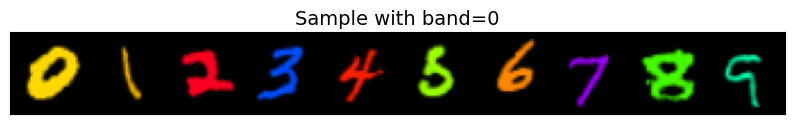

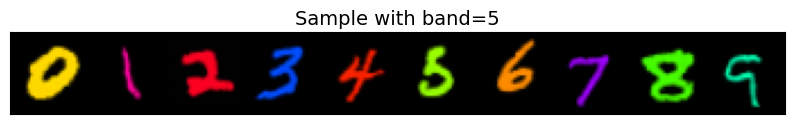

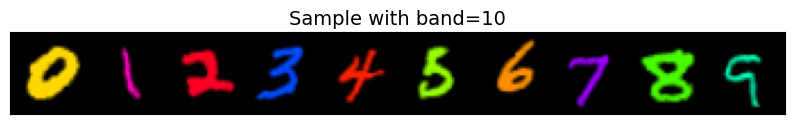

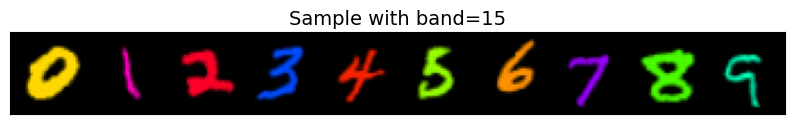

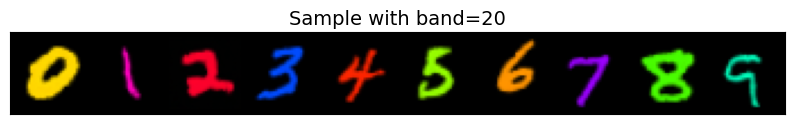

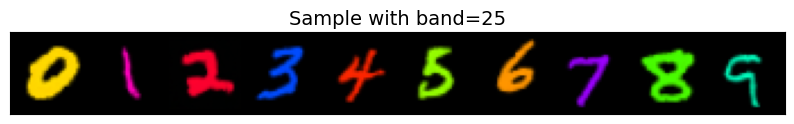

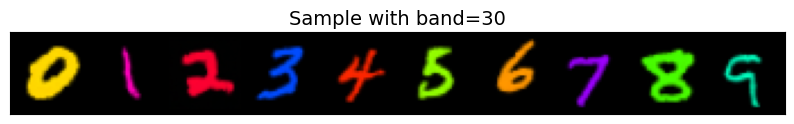

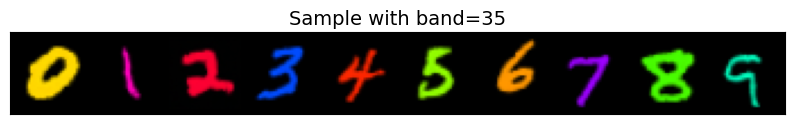

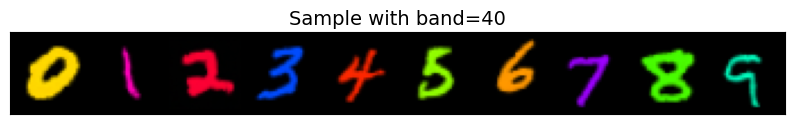

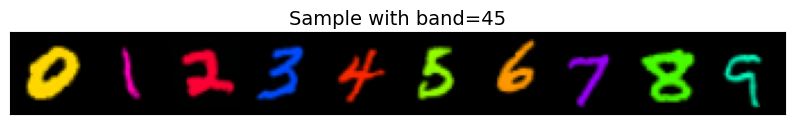

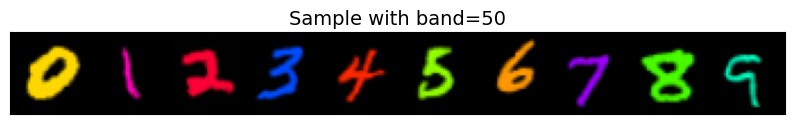

In [17]:
noise = torch.randn(10, 3, 32, 32, device="cuda")
bandwidth = np.arange(0, 55, 5)
for band in bandwidth:
    sampling_params = {
        'device': 'cuda',
        'sigma_min': 0.02,
        'sigma_max': 80.0,
        'num_steps': 50,
        'rho': 7.0,
        'vis_steps': 1,
        'stochastic': False,
        'cfg': 0.5,
        'iter_start': 50 // 2 - band // 2,
        'iter_end': 50 // 2 + band // 2,
    }
    class_labels = torch.eye(n=10, m=11).unsqueeze(0).repeat(1, 1, 1).reshape(-1, 11).float().to("cuda")
    img, _ = sample_euler(cond_model, noise, sampling_params, class_labels=class_labels)
    img  = img * 0.5 + 0.5
    visualize_batch(img.cpu().detach(), f'Sample with band={band}')

Видно следующее: сначала увеличение ширины окна улучшает генерацию, а дальше cfg начинает немного шакалить картинки. Видно, что у 6 появляется хвостик, а у 9 внизу размытие. Поэтому ширина 15-20 звучит как лучший вариант.

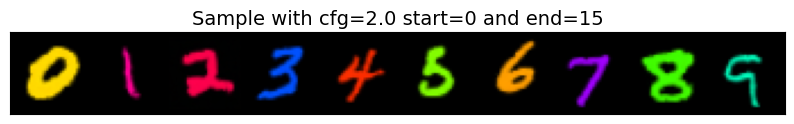

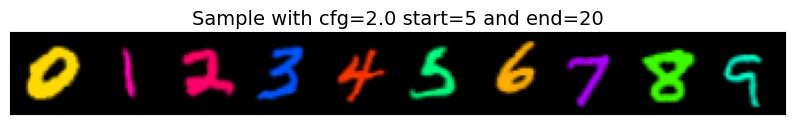

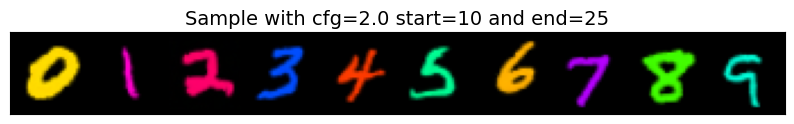

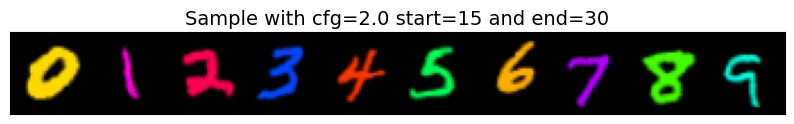

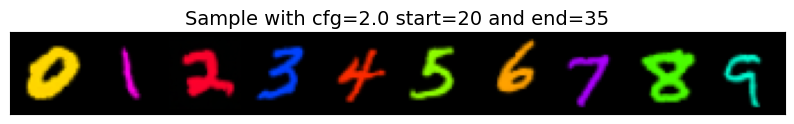

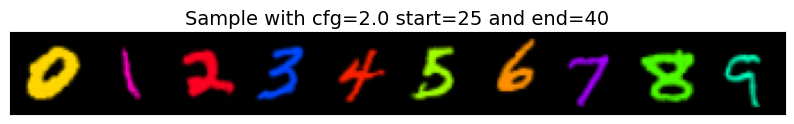

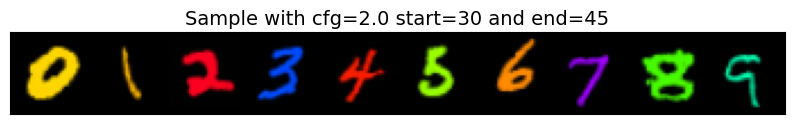

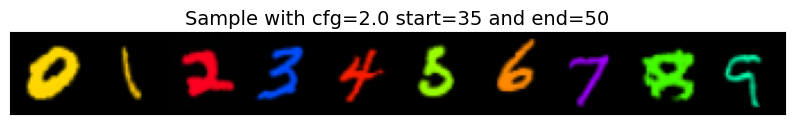

In [18]:
band = 15
start_list = np.arange(0, 40, 5)
for start in start_list:
    sampling_params = {
        'device': 'cuda',
        'sigma_min': 0.02,
        'sigma_max': 80.0,
        'num_steps': 50,
        'rho': 7.0,
        'vis_steps': 1,
        'stochastic': False,
        'cfg': 2.0,
        'iter_start': start,
        'iter_end': start + band,
    }
    class_labels = torch.eye(n=10, m=11).unsqueeze(0).repeat(1, 1, 1).reshape(-1, 11).float().to("cuda")
    img, _ = sample_euler(cond_model, noise, sampling_params, class_labels=class_labels)
    img  = img * 0.5 + 0.5
    visualize_batch(img.cpu().detach(), f'Sample with cfg={sampling_params["cfg"]} start={start} and end={start + band}')

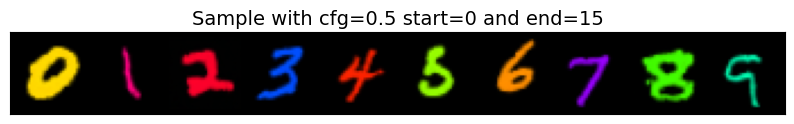

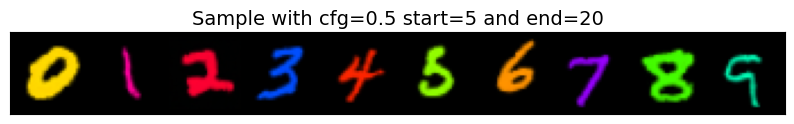

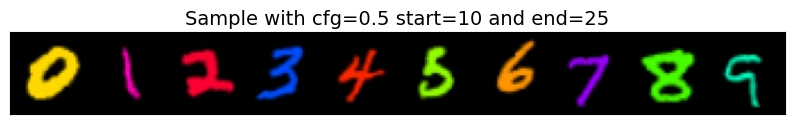

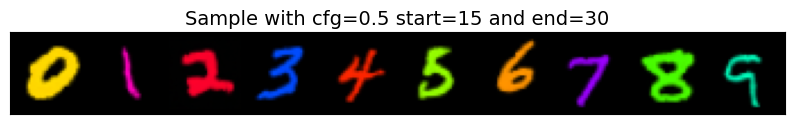

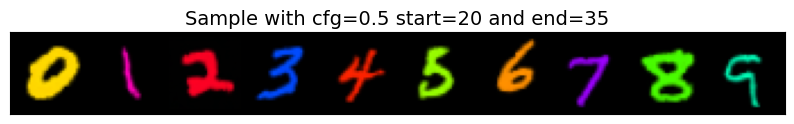

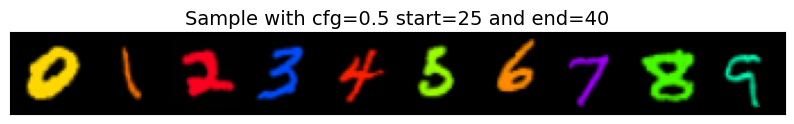

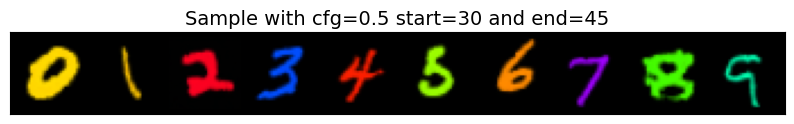

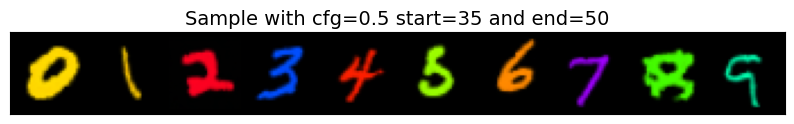

In [19]:
band = 15
start_list = np.arange(0, 40, 5)
for start in start_list:
    sampling_params = {
        'device': 'cuda',
        'sigma_min': 0.02,
        'sigma_max': 80.0,
        'num_steps': 50,
        'rho': 7.0,
        'vis_steps': 1,
        'stochastic': False,
        'cfg': 0.5,
        'iter_start': start,
        'iter_end': start + band,
    }
    class_labels = torch.eye(n=10, m=11).unsqueeze(0).repeat(1, 1, 1).reshape(-1, 11).float().to("cuda")
    img, _ = sample_euler(cond_model, noise, sampling_params, class_labels=class_labels)
    img  = img * 0.5 + 0.5
    visualize_batch(img.cpu().detach(), f'Sample with cfg={sampling_params["cfg"]} start={start} and end={start + band}')

Тут мне кажется идея примерно такая же, как и в расшумлении картинок: на первых и последних итерациях диффузионке проще всего генерировать картинку, а вот в середине сложнее; поэтому в начале и в конце не надо мешать модельке, а в середине нужно дать "пинок" в нужную сторону.

## Задача 2
Используя те же самые гиперпараметры семплинга (sigma_min=0.02, sigma_max=80.0, num_steps=50, rho=7.0, stochastic=False):
Найдите такие гиперпарамеры CFG, чтобы FID полученных изображений (по 3000 картинок) был меньше, чем 2.8;
* **(0.2 балла)** при условии, что использовано не более 25 шагов CFG;
* **(0.1 балла)** При условии, что использовано не более 10 шагов CFG (подумайте, какой коэффициент CFG имеет смысл использовать в условии ограниченного бюджета);
* Подробно распишите ваш процесс поиска оптимальных гиперпараметров: какой логикой вы руководствовались, как осуществляли перебор, как в итоге нашли полученные гиперпараметры. Два первых пункта без этого не принимаются (угадать нужные гиперпараметры практически невозможно, а описание процедуры в какой-то мере гарантирует самостоятельность результатов).
* **(0.2 балла)** Сохраните все тройки вида (середина окна, ширина окна, FID), полученные в результате запусков ваших экспериментов. Попробуйте визуализировать собранную статистику и проанализировать ее, сопоставив с наблюдениями из первой задачи. Полезным здесь может быть визуализация результатов в виде двумерной heatmap (например, с помощью функции *pcolormesh* из *Matplotlib*) или иллюстрация графика зависимости FID от ширины окна при разных фиксированных серединах окна, или, если было перебрано небольшое количество гиперпараметров, scatter plot с осями (середина окна, ширина окна) и цветом, визуализирующем значение FID.

In [24]:
sampling_params = {
                    'device': 'cuda',
                    'sigma_min': 0.02,
                    'sigma_max': 80.0,
                    'num_steps': 50,
                    'rho': 7.0,
                    'vis_steps': 1,
                    'stochastic': False,
                    'cfg': 0.5,
                    'iter_start': 20,
                    'iter_end': 30,
                }
save_model_samples('cunet_cond_samples', cond_model, sampling_params, batch_size=128, num_samples=3000, labels_usage='uniform')
fid = calc_fid('cunet_cond_samples', 'cmnist_train.npz', num_expected=3000, batch=128)
print('Модель с cfg = %.2g имеет FID = %.4g' % (sampling_params['cfg'], fid,))

3000 images saved: 100%|██████████| 3000/3000 [01:27<00:00, 34.15it/s]


Loading Inception-v3 model...
Loading images from "cunet_cond_samples"...
Calculating statistics for 3000 images...


100%|██████████| 24/24 [00:05<00:00,  4.06batch/s]


Модель с cfg = 0.5 имеет FID = 2.788


Идею писал выше, но ещё раз: раз окно не больше 10, то берём 10, коэффициент CFG берём 0.5, вроде с ним нормально работает; центром окна будет центр генерации, ведь в середине самая сложная задача.